### Set up the notebook

In [1]:
import malariagen_data
import numpy as np
import scipy
import pandas as pd
import xarray as xr
import allel
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
ag3 = malariagen_data.Ag3(pre = True)

In [3]:
sample_set = '1246-VO-TZ-KABULA-VMF00185'


In [4]:
# Load and remove siblings
sibs = pd.read_csv("../NGSrelate/full_relatedness_tanzania/sib_group_table.csv", sep="\t")
high_contamination = pd.read_csv('../NGSrelate/full_relatedness_tanzania/samples_to_exclude.csv', header = None)
exclude = list(sibs.query("keep == False")['sample.name']) + list(high_contamination[0])
exclude

['EA18-0152',
 'EA18-0393',
 'EA18-0404',
 'EA18-0452',
 'EA18-0571',
 'EA18-0423',
 'EA18-0539',
 'EA18-0478',
 'EA18-0440',
 'EA18-0468',
 'EA18-0488',
 'EA18-0489',
 'EA18-0511',
 'EA18-0527',
 'EA18-0502',
 'EA18-0514',
 'EA18-0516',
 'EA18-0562',
 'EA18-0560',
 'EA18-0330',
 'EA18-0268',
 'EA18-0195',
 'EA18-0234']

### Load in the table of SNPs that we use to define haplotypes

In [5]:
hap_def = pd.read_csv('Kdr_marker_SNPs.csv', sep = '\t', index_col = 0)
hap_def['variant_pos'] = hap_def['SNP Position'].str.replace('.*:', '', regex = True).astype('int')
hap_def

,SNP Position,Allele1,Allele1 interpretation,Allele2,Allele2 interpretation,variant_pos
SNP name,,,,,,
kdr-995S,2L:2422651,T,Not KdrS,C,KdrS,2422651
kdr-995F,2L:2422652,A,Not KdrF,T,KdrF,2422652
Def-S4S5,2L:2403941,T,Not S4S5,C,kdr haplotype cluster S4 or S5,2403941
Def-F3F4-2,2L:2414062,A,Not F3F4,T,kdr haplotype cluster F3 or F4,2414062
Def-F3,2L:2399997,G,Not F3,C,kdr haplotype cluster F3,2399997
Def-F2,2L:2425052,G,Not F2,A,kdr haplotype cluster F2,2425052
Def-S1-3,2L:2380982,T,Not S1,C,kdr haplotype cluster S1,2380982
Def-S5,2L:2408677,A,Not S5,C,kdr haplotype cluster S5,2408677
Def-F5-2,2L:2381706,A,Not F5,G,kdr haplotype cluster F5,2381706


### The functions for making the kdr background calls

In [6]:
# Determine kdr F origin for a genotype
def _F_kdr_origin_gen(genotypes):
    if 'sample_name' in genotypes.index:
        sample_name = genotypes['sample_name']
    else:
        sample_name = genotypes.name
    # Check for the 995F mutations
    if pd.isnull(genotypes['kdr-995F']):
        kdr_F_origins = 'F:unknown'
    elif genotypes['kdr-995F'] == 'AA':
        kdr_F_origins = 'F:wt_hom'
    elif genotypes['kdr-995F'] == 'AT':
        kdr_F_origins = 'F:het'
    elif genotypes['kdr-995F'] == 'TT':
        kdr_F_origins = 'F:hom'
    # If the individual has Fkdr, find out its origins
    # For F homozygotes
    if kdr_F_origins == 'F:hom':
        if pd.isnull(genotypes['Def-F1']):
            kdr_F_origins = f'{kdr_F_origins},F1?'
        elif genotypes['Def-F1'] == 'AA':
            kdr_F_origins = f'{kdr_F_origins},F1_hom'
        elif genotypes['Def-F1'] == 'AG':
            kdr_F_origins = f'{kdr_F_origins},F1_het'
        #
        if pd.isnull(genotypes['Def-F2']):
            kdr_F_origins = f'{kdr_F_origins},F2?'
        elif genotypes['Def-F2'] == 'AA':
            kdr_F_origins = f'{kdr_F_origins},F2_hom'
        elif genotypes['Def-F2'] == 'AG':
            kdr_F_origins = f'{kdr_F_origins},F2_het'
        #
        if pd.isnull(genotypes['Def-F3F4-2']):
            kdr_F_origins = f'{kdr_F_origins},F3F4?'
        elif genotypes['Def-F3F4-2'] == 'TT':
            if pd.isnull(genotypes['Def-F3']):
                kdr_F_origins = f'{kdr_F_origins},(F3F4)_hom'
            elif genotypes['Def-F3'] == 'CC':
                kdr_F_origins = f'{kdr_F_origins},F3_hom'
            elif genotypes['Def-F3'] == 'CG':
                kdr_F_origins = f'{kdr_F_origins},F3_het,F4_het'
            elif genotypes['Def-F3'] == 'GG':
                kdr_F_origins = f'{kdr_F_origins},F4_hom'
        elif genotypes['Def-F3F4-2'] == 'AT':
            if pd.isnull(genotypes['Def-F3']):
                kdr_F_origins = f'{kdr_F_origins},(F3F4)_het'
            elif genotypes['Def-F3'] == 'CC':
                return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for F3F4, but homozygote for F3.')
            elif genotypes['Def-F3'] == 'CG':
                kdr_F_origins = f'{kdr_F_origins},F3_het'
            elif genotypes['Def-F3'] == 'GG':
                kdr_F_origins = f'{kdr_F_origins},F4_het'
        #
        if pd.isnull(genotypes['Def-F5-2']):
            kdr_F_origins = f'{kdr_F_origins},F5?'
        elif genotypes['Def-F5-2'] == 'GG':
            kdr_F_origins = f'{kdr_F_origins},F5_hom'
        elif genotypes['Def-F5-2'] == 'AG':
            kdr_F_origins = f'{kdr_F_origins},F5_het'
    # for F heterozygotes
    elif kdr_F_origins == 'F:het':
        if pd.isnull(genotypes['Def-F1']):
            kdr_F_origins = f'{kdr_F_origins},F1?'
        elif genotypes['Def-F1'] == 'AA':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for F kdr, but homozygote for F1.')
        elif genotypes['Def-F1'] == 'AG':
            kdr_F_origins = f'{kdr_F_origins},F1_het'
        #
        if pd.isnull(genotypes['Def-F2']):
            kdr_F_origins = f'{kdr_F_origins},F2?'
        elif genotypes['Def-F2'] == 'AA':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for F kdr, but homozygote for F2.')
        elif genotypes['Def-F2'] == 'AG':
            kdr_F_origins = f'{kdr_F_origins},F2_het'
        #
        if pd.isnull(genotypes['Def-F3F4-2']):
            kdr_F_origins = f'{kdr_F_origins},F3F4?'
        elif genotypes['Def-F3F4-2'] == 'TT':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for F kdr, but homozygote for F3F4.')
        elif genotypes['Def-F3F4-2'] == 'AT':
            if pd.isnull(genotypes['Def-F3']):
                kdr_F_origins = f'{kdr_F_origins},(F3F4)_het'
            elif genotypes['Def-F3'] == 'CC':
                return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for F kdr and F3F4, but homozygote for F3.')
            elif genotypes['Def-F3'] == 'CG':
                kdr_F_origins = f'{kdr_F_origins},F3_het'
            elif genotypes['Def-F3'] == 'GG':
                kdr_F_origins = f'{kdr_F_origins},F4_het'
        #
        if pd.isnull(genotypes['Def-F5-2']):
            kdr_F_origins = f'{kdr_F_origins},F5?'
        elif genotypes['Def-F5-2'] == 'GG':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for F kdr, but homozygote for F5.')
        elif genotypes['Def-F5-2'] == 'AG':
            kdr_F_origins = f'{kdr_F_origins},F5_het'
    return(kdr_F_origins)


# Determine kdr S origin for a genotype
def _S_kdr_origin_gen(genotypes, alternate_S4S5 = False):
    if 'sample_name' in genotypes.index:
        sample_name = genotypes['sample_name']
    else:
        sample_name = genotypes.name
    # Check for the 995S mutations
    if pd.isnull(genotypes['kdr-995S']):
        kdr_S_origins = 'S:unknown'
    elif genotypes['kdr-995S'] == 'TT':
        kdr_S_origins = 'S:wt_hom'
    elif genotypes['kdr-995S'] == 'CT':
        kdr_S_origins = 'S:het'
    elif genotypes['kdr-995S'] == 'CC':
        kdr_S_origins = 'S:hom'
    # If the individual has Skdr, find out its origins
    # For S homozygotes
    if kdr_S_origins == 'S:hom':
        if pd.isnull(genotypes['Def-S1-3']):
            kdr_S_origins = f'{kdr_S_origins},S1?'
        elif genotypes['Def-S1-3'] == 'CC':
            kdr_S_origins = f'{kdr_S_origins},S1_hom'
        elif genotypes['Def-S1-3'] == 'CT':
            kdr_S_origins = f'{kdr_S_origins},S1_het'
        #
        if pd.isnull(genotypes['Def-S2S4']):
            kdr_S_origins = f'{kdr_S_origins},S2S4?'
        elif genotypes['Def-S2S4'] == 'TT':
            if pd.isnull(genotypes['Def-S2-4']):
                kdr_S_origins = f'{kdr_S_origins},(S2S4)_hom'
            elif genotypes['Def-S2-4'] == 'AA':
                kdr_S_origins = f'{kdr_S_origins},S2_hom'
            elif genotypes['Def-S2-4'] == 'AT':
                kdr_S_origins = f'{kdr_S_origins},S2_het,S4_het'
            elif genotypes['Def-S2-4'] == 'TT':
                kdr_S_origins = f'{kdr_S_origins},S4_hom'
        elif genotypes['Def-S2S4'] == 'CT':
            if pd.isnull(genotypes['Def-S2_4']):
                kdr_S_origins = f'{kdr_S_origins},(S2S4)_het'
            elif genotypes['Def-S2-4'] == 'AA':
                return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S2S4, but homozygote for S2.')
            elif genotypes['Def-S2-4'] == 'AT':
                kdr_S_origins = f'{kdr_S_origins},S2_het'
            elif genotypes['Def-S2-4'] == 'TT':
                kdr_S_origins = f'{kdr_S_origins},S4_het'
        #
        if pd.isnull(genotypes['Def-S3']):
            kdr_S_origins = f'{kdr_S_origins},S3?'
        elif genotypes['Def-S3'] == 'GG':
            kdr_S_origins = f'{kdr_S_origins},S3_hom'
        elif genotypes['Def-S3'] == 'GT':
            kdr_S_origins = f'{kdr_S_origins},S3_het'
        # 
        if alternate_S4S5:
            if pd.isnull(genotypes['Def-S4S5-2']):
                kdr_S_origins = f'{kdr_S_origins},S4S5?'
            elif genotypes['Def-S4S5-2'] == 'TT':
                if pd.isnull(genotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},(S4S5)_hom'
                elif genotypes['Def-S5'] == 'CC':
                    kdr_S_origins = f'{kdr_S_origins},S5_hom'
                elif genotypes['Def-S5'] == 'AC':
                    kdr_S_origins = f'{kdr_S_origins},S5_het,S4_het'
                elif genotypes['Def-S5'] == 'AA':
                    kdr_S_origins = f'{kdr_S_origins},S4_hom'
            elif genotypes['Def-S4S5-2'] == 'GT':
                if pd.isnull(genotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},(S4S5)_het'
                elif genotypes['Def-S5'] == 'CC':
                    return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S4S5, but homozygote for S5.')
                elif genotypes['Def-S5'] == 'AC':
                    kdr_S_origins = f'{kdr_S_origins},S5_het'
                elif genotypes['Def-S5'] == 'AA':
                    kdr_S_origins = f'{kdr_S_origins},S4_het'
        else :
            if pd.isnull(genotypes['Def-S4S5']):
                kdr_S_origins = f'{kdr_S_origins},S4S5?'
            elif genotypes['Def-S4S5'] == 'CC':
                if pd.isnull(genotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},(S4S5)_hom'
                elif genotypes['Def-S5'] == 'CC':
                    kdr_S_origins = f'{kdr_S_origins},S5_hom'
                elif genotypes['Def-S5'] == 'AC':
                    kdr_S_origins = f'{kdr_S_origins},S4_het,S5_het'
                elif genotypes['Def-S5'] == 'AA':
                    kdr_S_origins = f'{kdr_S_origins},S4_hom'
            elif genotypes['Def-S4S5'] == 'CT':
                if pd.isnull(genotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},(S4S5)_het'
                elif genotypes['Def-S5'] == 'CC':
                    return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S4S5, but homozygote for S5.')
                elif genotypes['Def-S5'] == 'AC':
                    kdr_S_origins = f'{kdr_S_origins},S5_het'
                elif genotypes['Def-S5'] == 'AA':
                    kdr_S_origins = f'{kdr_S_origins},S4_het'
    # for S heterozygotes
    elif kdr_S_origins == 'S:het':
        if pd.isnull(genotypes['Def-S1-3']):
            kdr_S_origins = f'{kdr_S_origins},S1?'
        elif genotypes['Def-S1-3'] == 'CC':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr, but homozygote for S1.')
        elif genotypes['Def-S1-3'] == 'CT':
            kdr_S_origins = f'{kdr_S_origins},S1_het'
        #
        if pd.isnull(genotypes['Def-S2S4']):
            kdr_S_origins = f'{kdr_S_origins},S2S4?'
        elif genotypes['Def-S2S4'] == 'TT':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr, but homozygote for S2S4.')
        elif genotypes['Def-S2S4'] == 'CT':
            if pd.isnull(genotypes['Def-S2-4']):
                kdr_S_origins = f'{kdr_S_origins},(S2S4)_het'
            elif genotypes['Def-S2-4'] == 'AA':
                return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr and S2S4, but homozygote for S2.')
            elif genotypes['Def-S2-4'] == 'AT':
                kdr_S_origins = f'{kdr_S_origins},S2_het'
            elif genotypes['Def-S2-4'] == 'TT':
                kdr_S_origins = f'{kdr_S_origins},S4_het'
        #
        if pd.isnull(genotypes['Def-S3']):
            kdr_S_origins = f'{kdr_S_origins},S3?'
        elif genotypes['Def-S3'] == 'GG':
            return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr, but homozygote for S3.')
        elif genotypes['Def-S3'] == 'GT':
            kdr_S_origins = f'{kdr_S_origins},S3_het'
        # 
        if alternate_S4S5:
            if pd.isnull(genotypes['Def-S4S5_2']):
                kdr_S_origins = f'{kdr_S_origins},S4S5?'
            elif genotypes['Def-S4S5-2'] == 'TT':
                return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr, but homozygote for S4S5.')
            elif genotypes['Def-S4S5-2'] == 'GT':
                if pd.isnull(genotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},(S4S5)_het'
                elif genotypes['Def-S5'] == 'CC':
                    return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr and S4S5, but homozygote for S5.')
                elif genotypes['Def-S5'] == 'AC':
                    kdr_S_origins = f'{kdr_S_origins},S5_het'
                elif genotypes['Def-S5'] == 'AA':
                    kdr_S_origins = f'{kdr_S_origins},S4_het'
        else :
            if pd.isnull(genotypes['Def-S4S5']):
                kdr_S_origins = f'{kdr_S_origins},S4S5?'
            elif genotypes['Def-S4S5'] == 'CC':
                return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr, but homozygote for S4S5.')
            elif genotypes['Def-S4S5'] == 'CT':
                if pd.isnull(genotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},(S4S5)_het'
                elif genotypes['Def-S5'] == 'CC':
                    return(f'Fail. Genotypes suggest that sample {sample_name} is heterozygote for S kdr and S4S5, but homozygote for S5.')
                elif genotypes['Def-S5'] == 'AC':
                    kdr_S_origins = f'{kdr_S_origins},S5_het'
                elif genotypes['Def-S5'] == 'AA':
                    kdr_S_origins = f'{kdr_S_origins},S4_het'
    return(kdr_S_origins)


# Determine kdr F origin for a haploptype
def _F_kdr_origin_hap(haplotypes, clean = True):
    if 'sample_name' in haplotypes.index:
        sample_name = haplotypes['sample_name']
    else:
        sample_name = haplotypes.name
    # Check for the 995F mutations
    if pd.isnull(haplotypes['kdr-995F']):
        kdr_F_origins = 'F:?'
    elif haplotypes['kdr-995F'] == 'A':
        kdr_F_origins = 'F:wt'
    elif haplotypes['kdr-995F'] == 'T':
        kdr_F_origins = 'F:mut'
    # If the individual has Fkdr, find out its origins
    # For F homozygotes
    if kdr_F_origins == 'F:mut':
        if pd.isnull(haplotypes['Def-F1']):
            kdr_F_origins = f'{kdr_F_origins},F1?'
        elif haplotypes['Def-F1'] == 'A':
            kdr_F_origins = f'{kdr_F_origins},F1'
        #
        if pd.isnull(haplotypes['Def-F2']):
            kdr_F_origins = f'{kdr_F_origins},F2?'
        elif haplotypes['Def-F2'] == 'A':
            kdr_F_origins = f'{kdr_F_origins},F2'
        #
        if pd.isnull(haplotypes['Def-F3F4-2']):
            kdr_F_origins = f'{kdr_F_origins},F3F4?'
        elif haplotypes['Def-F3F4-2'] == 'T':
            if pd.isnull(haplotypes['Def-F3']):
                kdr_F_origins = f'{kdr_F_origins},F3/F4'
            elif haplotypes['Def-F3'] == 'C':
                kdr_F_origins = f'{kdr_F_origins},F3'
            elif haplotypes['Def-F3'] == 'G':
                kdr_F_origins = f'{kdr_F_origins},F4'
        #
        if pd.isnull(haplotypes['Def-F5-2']):
            kdr_F_origins = f'{kdr_F_origins},F5?'
        elif haplotypes['Def-F5-2'] == 'G':
            kdr_F_origins = f'{kdr_F_origins},F5'
    if clean:
        return(_kdr_hap_cleanup(kdr_F_origins))
    else:
        return(kdr_F_origins)

    
# Determine kdr S origin for a haploptype
def _S_kdr_origin_hap(haplotypes, clean = True, alternate_S4S5 = False):
    if 'sample_name' in haplotypes.index:
        sample_name = haplotypes['sample_name']
    else:
        sample_name = haplotypes.name
    # Check for the 995S mutations
    if pd.isnull(haplotypes['kdr-995S']):
        kdr_S_origins = 'S:?'
    elif haplotypes['kdr-995S'] == 'T':
        kdr_S_origins = 'S:wt'
    elif haplotypes['kdr-995S'] == 'C':
        kdr_S_origins = 'S:mut'
    # If the individual has Skdr, find out its origins
    # For S homozygotes
    if kdr_S_origins == 'S:mut':
        if pd.isnull(haplotypes['Def-S1-3']):
            kdr_S_origins = f'{kdr_S_origins},S1?'
        elif haplotypes['Def-S1-3'] == 'C':
            kdr_S_origins = f'{kdr_S_origins},S1'
        #
        if pd.isnull(haplotypes['Def-S2S4']):
            kdr_S_origins = f'{kdr_S_origins},S2S4?'
        elif haplotypes['Def-S2S4'] == 'T':
            if pd.isnull(haplotypes['Def-S2-4']):
                kdr_S_origins = f'{kdr_S_origins},S2/S4'
            elif haplotypes['Def-S2-4'] == 'A':
                kdr_S_origins = f'{kdr_S_origins},S2'
            elif haplotypes['Def-S2-4'] == 'T':
                kdr_S_origins = f'{kdr_S_origins},S4'
        #
        if pd.isnull(haplotypes['Def-S3']):
            kdr_S_origins = f'{kdr_S_origins},S3?'
        elif haplotypes['Def-S3'] == 'G':
            kdr_S_origins = f'{kdr_S_origins},S3'
        # 
        if alternate_S4S5:
            if pd.isnull(haplotypes['Def-S4S5-2']):
                kdr_S_origins = f'{kdr_S_origins},S4S5?'
            elif haplotypes['Def-S4S5-2'] == 'T':
                if pd.isnull(haplotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},S4/S5'
                elif haplotypes['Def-S5'] == 'C':
                    kdr_S_origins = f'{kdr_S_origins},S5'
                elif haplotypes['Def-S5'] == 'A':
                    kdr_S_origins = f'{kdr_S_origins},S4'
        else :
            if pd.isnull(haplotypes['Def-S4S5']):
                kdr_S_origins = f'{kdr_S_origins},S4S5?'
            elif haplotypes['Def-S4S5'] == 'C':
                if pd.isnull(haplotypes['Def-S5']):
                    kdr_S_origins = f'{kdr_S_origins},S4/S5'
                elif haplotypes['Def-S5'] == 'C':
                    kdr_S_origins = f'{kdr_S_origins},S5'
                elif haplotypes['Def-S5'] == 'A':
                    kdr_S_origins = f'{kdr_S_origins},S4'
    if clean:
        return(_kdr_hap_cleanup(kdr_S_origins))
    else:
        return(kdr_S_origins)


# The initial output of the kdr_origin function can be a little messy, since it outputs all of the 
# information that it could or couldn't obtain. This function tidies it up a bit. 
def _kdr_hap_cleanup(kdr_origin_str):
    if re.search('wt', kdr_origin_str):
        return('wt')
    if not re.search('mut', kdr_origin_str):
        return('?')
    kdr_type = kdr_origin_str[0]
    outcomes = kdr_origin_str.split(',')
    if len(outcomes) == 1:
        return(kdr_type)
    origins = outcomes[1:]
    established_origins = [o for o in origins if not re.search('\?', o)]
    if len(established_origins) == 1:
        return(established_origins[0])
    else:
        return(','.join(origins))


# Single function to call both the F and S origins for a given haplotype. This function determines
# from the look of the genotype table whether it represents genotypes or haplotypes, and calls 
# the appropriate function. 
def kdr_origin(genotypes, alternate_S4S5 = False, clean = True):
    if 'sample_name' in genotypes.index:
        sample_name = genotypes['sample_name']
    else:
        sample_name = genotypes.name
    if len(genotypes[0]) == 1:
        kdr_origins = pd.DataFrame({'kdr_F_origin': [_F_kdr_origin_hap(genotypes, clean)], 
                                    'kdr_S_origin': [_S_kdr_origin_hap(genotypes, clean, alternate_S4S5)]
                                   }, index = [sample_name]
    )
    else:
        kdr_origins = pd.DataFrame({'kdr_F_origin': [_F_kdr_origin_gen(genotypes)], 
                                    'kdr_S_origin': [_S_kdr_origin_gen(genotypes, alternate_S4S5)]
                                   }, index = [sample_name]
    )
    return(kdr_origins)

# From a pair of haplotype level kdr origin calls (obtained by running the kdr_origin function 
# for each of F and S, followed by kdr_hap_cleanup), output a single call combining the F and
# S calls. 
def get_single_hap_call(x):
    if x['kdr_F_origin'] == 'wt':
        output = x['kdr_S_origin']
    else:
        if x['kdr_S_origin'] == 'wt':
            output = x['kdr_F_origin']
        else :
            if x['kdr_F_origin'] == '?':
                if x['kdr_S_origin'] == '?':
                    output = 'unknown'
                else:
                    output = x['kdr_S_origin']
            else:
                if x['kdr_S_origin'] == '?':
                    output = 'kdr_F_origin'
                else:
                    output = 'unknown'
    if output == '?':
        output = 'unknown'
    if output not in ['wt', 'F', 'F1', 'F2', 'F3', 'F4', 'F5', 'S', 'S1', 'S2', 'S3', 'S4', 'S5']:
        output = output[0]
    return(output)
    

### The hierarchical clustering and plotting functions

In [7]:
def find_clusters(dist, n, threshold=0.001, method='complete'):
        # build hierarchy
        clust = scipy.cluster.hierarchy.linkage(dist, method=method)
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(clust, threshold,
                                             criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        return clusters

def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

def plot_dendrogram(zhier, ax, h, method='complete', color_threshold=0, above_threshold_color='k'):

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(zhier, no_labels=True, count_sort=True,
                                           color_threshold=color_threshold,
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-.0001)

    ax.set_ylabel(r'$d_{xy}$')
    ax.autoscale(axis='x', tight=True)
    return r

def draw_hap_cluster_plot(z, h, 
                          set_colour_scheme, kdr_colour_scheme, 
                          labels_for_set_colours, labels_for_kdr_colours, 
                          add_legend = True, title = '',
                          fn = None):

    gs = GridSpec(3, 1, height_ratios=[4.0, 0.4, 0.4])
    fig = plt.figure(figsize=(15, 6))

    plt.subplots_adjust(hspace=0.02)
    ax1 = plt.subplot(gs[0])
    sns.despine(ax=ax1, offset=5, bottom=True, top=True)
    r = plot_dendrogram(z, ax1, h)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylim(0)

    ax_kdr = fig.add_subplot(gs[1])

    x_kdr = labels_for_kdr_colours.take(r['leaves'])
    hap_kdr_clrs = [kdr_colour_scheme[p] for p in x_kdr]
    ax_kdr.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                       yrange=(0, 1),
                       color=hap_kdr_clrs);
    sns.despine(ax=ax_kdr, offset=5, left=True, bottom=True, top=True)

    ax_kdr.set_xticks([])
    ax_kdr.set_yticks([])
    ax_kdr.set_xlim(0, h.shape[1])
    ax_kdr.yaxis.set_label_position('left')
    ax_kdr.set_ylabel('kdr origin', rotation=0, ha='right', va='center')

    ax_sets = fig.add_subplot(gs[2])

    x_set = labels_for_set_colours.take(r['leaves'])
    hap_set_clrs = [set_colour_scheme[p] for p in x_set]
    ax_sets.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                        yrange=(0, 1),
                        color=hap_set_clrs);
    sns.despine(ax=ax_sets, offset=5, left=True, bottom=True)
    
    ax_sets.set_xticks([])
    ax_sets.set_yticks([])
    ax_sets.set_xlim(0, h.shape[1])
    ax_sets.yaxis.set_label_position('left')
    ax_sets.set_ylabel('Sample set', rotation=0, ha='right', va='center')
    
    if add_legend:
        plot_x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
        plot_y_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
        legend_x = ax1.get_xlim()[0] + plot_x_range * 0.95
            
        unique_label_kdr = np.unique(x_kdr)
        for i, k in enumerate(unique_label_kdr[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * i)
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = kdr_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)

        
        unique_label_set = np.unique(x_set)
        for j, k in enumerate(unique_label_set[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * (i + 2 + j))
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = set_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)



    ax1.set_title(f'{title}')
    ax1.autoscale()
    fig.patch.set_alpha(1)
    
    if fn != None:
        ext = re.sub('.*\.', '', fn)
        plt.savefig(fn, format = ext)



### Run the analysis

Get the genotype calls for the focal samples

In [8]:
# This is the genomic range across which we find the SNPs used to infer kdr origin
kdr_origin_range = '2L:2380900-2435600'
focal_snp_calls = (
    ag3.snp_calls(region = kdr_origin_range, 
                  sample_sets = sample_set,
                  sample_query=f"partner_sample_id not in {list(exclude)}")
    .set_index(variants = 'variant_position')
    .sel(variants = xr.DataArray(hap_def['variant_pos']))
)
focal_sample_order = focal_snp_calls.sample_id.values
focal_snp_calls


<xarray.Dataset>
Dimensions:                             (SNP name: 14, alleles: 4,
                                         samples: 444, ploidy: 2)
Coordinates:
    variant_contig                      (SNP name) uint8 dask.array<chunksize=(14,), meta=np.ndarray>
    sample_id                           (samples) <U36 dask.array<chunksize=(444,), meta=np.ndarray>
    variants                            (SNP name) int32 2422651 ... 2408423
  * SNP name                            (SNP name) object 'kdr-995S' ... 'Def...
Dimensions without coordinates: alleles, samples, ploidy
Data variables:
    variant_allele                      (SNP name, alleles) |S1 dask.array<chunksize=(14, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (SNP name) bool dask.array<chunksize=(14,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (SNP name) bool dask.array<chunksize=(14,), meta=np.ndarray>
    variant_filter_pass_arab            (SNP name) bool dask.array<chunksize=(14,), meta=np.ndarray>
    call_genotype                       (SNP name, samples, ploidy) int8 dask.array<chunksize=(14, 50, 2), meta=np.ndarray>
    call_GQ                             (SNP name, samples) int8 dask.array<chunksize=(14, 50), meta=np.ndarray>
    call_MQ                             (SNP name, samples) float32 dask.array<chunksize=(14, 50), meta=np.ndarray>
    call_AD                             (SNP name, samples, alleles) int16 dask.array<chunksize=(14, 50, 4), meta=np.ndarray>
    call_genotype_mask                  (SNP name, samples, ploidy) bool dask.array<chunksize=(14, 50, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Get the kdr origin calls at the genotype level

In [9]:
focal_snp_alleles = focal_snp_calls.variant_allele.compute().values.astype('str')
focal_snp_genotypes_3d = focal_snp_alleles[
    np.array(range(focal_snp_alleles.shape[0])).reshape(focal_snp_alleles.shape[0], 1, 1), 
    focal_snp_calls.call_genotype
]

focal_snp_genotypes = np.apply_along_axis(lambda x: ''.join(np.sort(x)), 2, focal_snp_genotypes_3d)

focal_gen_df = pd.DataFrame(
    np.transpose(focal_snp_genotypes), 
    index = focal_sample_order,
    columns = hap_def.index
)

focal_kdr_origins = pd.concat([kdr_origin(focal_gen_df.iloc[i]) for i in range(focal_gen_df.shape[0])])
focal_kdr_origins


,kdr_F_origin,kdr_S_origin
VBS54893-6781STDY12150017,F:wt_hom,S:wt_hom
VBS54894-6781STDY12150018,F:wt_hom,S:wt_hom
VBS54895-6781STDY12150019,F:wt_hom,S:wt_hom
VBS54898-6781STDY12150021,F:wt_hom,S:wt_hom
VBS54901-6781STDY12150024,F:wt_hom,S:wt_hom
...,...,...
VBS55417-6781STDY12150536,F:wt_hom,S:wt_hom
VBS55419-6781STDY12150538,F:wt_hom,S:wt_hom
VBS55420-6781STDY12150539,F:wt_hom,S:wt_hom
VBS55421-6781STDY12150540,F:wt_hom,S:wt_hom


In [10]:
print(focal_kdr_origins['kdr_F_origin'].value_counts())
print(focal_kdr_origins['kdr_S_origin'].value_counts())

F:wt_hom    442
F:het         2
Name: kdr_F_origin, dtype: int64
S:wt_hom    444
Name: kdr_S_origin, dtype: int64


Now get the haplotype calls for the samples of interest

In [11]:
focal_hap_calls = (
    ag3.haplotypes(region = kdr_origin_range, 
                   analysis = 'gamb_colu_arab', 
                   sample_sets = sample_set,
                   sample_query=f"partner_sample_id not in {list(exclude)}")
    .set_index(variants = 'variant_position')
)

focal_hap_sample_order = focal_hap_calls.sample_id.values

# Some background SNPs don't have haplotype calls. 
# Identify the kdr background SNPs for which there are haplotype data, and those for which there aren't
snps_with_hap_data = [x for x in hap_def['variant_pos'] if x in focal_hap_calls.variants.values]
snps_no_hap_data = [x for x in hap_def['variant_pos'] if x not in focal_hap_calls.variants.values]

# Now pull out the haplotype data where we have them
focal_hap_calls = focal_hap_calls.sel(variants = xr.DataArray(snps_with_hap_data, dims = 'variants'))
focal_hap_calls

<xarray.Dataset>
Dimensions:         (variants: 9, alleles: 2, samples: 444, ploidy: 2)
Coordinates:
    variant_contig  (variants) uint8 dask.array<chunksize=(9,), meta=np.ndarray>
    sample_id       (samples) object dask.array<chunksize=(444,), meta=np.ndarray>
  * variants        (variants) int32 2422651 2422652 2403941 ... 2425766 2432419
Dimensions without coordinates: alleles, samples, ploidy
Data variables:
    variant_allele  (variants, alleles) |S1 dask.array<chunksize=(9, 1), meta=np.ndarray>
    call_genotype   (variants, samples, ploidy) int8 dask.array<chunksize=(9, 64, 2), meta=np.ndarray>
Attributes:
    contigs:   ('2R', '2L', '3R', '3L', 'X')
    analysis:  gamb_colu_arab

Get the haplotypes coded as nucleotides

In [12]:
# Get the nucleotides represented by the wt / mut calls at each position
hap_alleles = focal_hap_calls.variant_allele.compute().values.astype('str')

# Use this to recode the haplotype calls to nucleotides
focal_snp_haplotypes = hap_alleles[
    np.array(range(hap_alleles.shape[0])).reshape(hap_alleles.shape[0], 1), 
    allel.GenotypeArray(focal_hap_calls.call_genotype).to_haplotypes()
]
focal_snp_haplotypes

array([['T', 'T', 'T', ..., 'T', 'T', 'T'],
       ['A', 'A', 'A', ..., 'A', 'A', 'A'],
       ['T', 'T', 'T', ..., 'T', 'T', 'T'],
       ...,
       ['G', 'G', 'G', ..., 'G', 'G', 'G'],
       ['T', 'T', 'T', ..., 'T', 'T', 'T'],
       ['T', 'T', 'T', ..., 'T', 'T', 'T']], dtype='<U1')

Determnine the kdr origin of the sample at the haplotype level. Some kdr origin markers don't have haplotype calls, which is why we lack some information at the haplotype level. 

In [13]:
# Get the names of the markers for which we have haplotype data
markers_with_hap_data = [hap_def.query('variant_pos == @x').index[0] for x in snps_with_hap_data]

# Convert the haplotype calls to a dataframe
focal_hap_df = pd.DataFrame(
    focal_snp_haplotypes.transpose(),
    index = np.repeat(focal_hap_sample_order, 2),
    columns = markers_with_hap_data
)

# Then add null values for the missing SNPs
markers_no_hap_data = [hap_def.query('variant_pos == @x').index[0] for x in snps_no_hap_data]
markers_no_hap_data
focal_hap_df[markers_no_hap_data] = np.nan

# Compute the kdr origins
focal_kdr_hap_origins = pd.concat([kdr_origin(focal_hap_df.iloc[i]) for i in range(focal_hap_df.shape[0])])
focal_kdr_hap_origins

,kdr_F_origin,kdr_S_origin
VBS54893-6781STDY12150017,wt,wt
VBS54893-6781STDY12150017,wt,wt
VBS54894-6781STDY12150018,wt,wt
VBS54894-6781STDY12150018,wt,wt
VBS54895-6781STDY12150019,wt,wt
...,...,...
VBS55420-6781STDY12150539,wt,wt
VBS55421-6781STDY12150540,wt,wt
VBS55421-6781STDY12150540,wt,wt
VBS55422-6781STDY12150541,wt,wt


Turn that into a single call per haplotype

In [14]:
focal_kdr_hap_origins['kdr_origin'] = focal_kdr_hap_origins.apply(
    get_single_hap_call, axis = 1
)

focal_kdr_hap_origins['kdr_origin'].value_counts()

wt    886
F       2
Name: kdr_origin, dtype: int64

So that gives us what we know about the kdr origin backgrouns present in our population. For greater confidence in those calls, let's map them onto the origin samples that were used to determine the different kdr origins in the first place. 

Get the haplotype calls from the same region used in the Clarkson paper to create the haplotype clustering tree. 

In [15]:
# define region (as in Clarkson paper)
hap_cluster_region = '2L:2358158-2431617'

# Get haplotypes for the phase 3 samples
kdr_region_haps = ag3.haplotypes(region = hap_cluster_region, 
                                 analysis = 'gamb_colu_arab',
                                 sample_sets = '3.0', 
).set_index(samples = 'sample_id')

kdr_hap_array = allel.GenotypeArray(kdr_region_haps.call_genotype).to_haplotypes()

# Now get the haplotypes from the focal samples
kdr_region_focal_haps = ag3.haplotypes(region = hap_cluster_region, 
                                       analysis = 'gamb_colu_arab',
                                       sample_sets = sample_set,
                                       sample_query=f"partner_sample_id not in {list(exclude)}"

)

focal_kdr_hap_array = allel.GenotypeArray(kdr_region_focal_haps.call_genotype).to_haplotypes()

# Now paste the arrays together
combined_kdr_hap_array = kdr_hap_array.concatenate(focal_kdr_hap_array, axis = 1)

# And remove non-segregating sites
ac = combined_kdr_hap_array.count_alleles()
# Filter the datasets, removing non-segregating variants 
combined_kdr_hap_array = combined_kdr_hap_array[ac.is_segregating()]
combined_kdr_hap_array


<HaplotypeArray shape=(9460, 6456) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

Now get kdr origin calls for the samples that were in phase 3. 

In [16]:
phase3_hap_calls = (
    ag3.haplotypes(region = kdr_origin_range, 
                   analysis = 'gamb_colu_arab', 
                   sample_sets = '3.0')
    .set_index(samples = 'sample_id', variants = 'variant_position')
)

# Now pull out the haplotype data
phase3_hap_calls = phase3_hap_calls.sel(variants = xr.DataArray(snps_with_hap_data, dims = 'variants'))

# Now encode as nucleotides
phase3_snp_haplotypes = hap_alleles[
    np.array(range(hap_alleles.shape[0])).reshape(hap_alleles.shape[0], 1), 
    allel.GenotypeArray(phase3_hap_calls.call_genotype).to_haplotypes()
]

# And convert to data frame
phase3_hap_df = pd.DataFrame(
    phase3_snp_haplotypes.transpose(),
    index = np.repeat(phase3_hap_calls.samples, 2),
    columns = markers_with_hap_data
)

# Then add null values for the missing SNPs
phase3_hap_df[markers_no_hap_data] = np.nan

# Finally, determine the kdr origins
phase3_kdr_hap_origins = pd.concat([kdr_origin(phase3_hap_df.iloc[i]) for i in range(phase3_hap_df.shape[0])])
phase3_kdr_hap_origins['kdr_origin'] = phase3_kdr_hap_origins.apply(
    get_single_hap_call, axis = 1
)

phase3_kdr_hap_origins['kdr_origin'].value_counts()


wt    2556
F     1806
S      527
F5     346
S3     312
F2      21
Name: kdr_origin, dtype: int64

Prepare the data for haplotype clustering

In [17]:
# Calculate the distance matrix 
dist = allel.pairwise_distance(combined_kdr_hap_array, metric = 'hamming')
site_filter = ag3.snp_calls(region=hap_cluster_region, sample_sets="3.0")['variant_filter_pass_gamb_colu_arab']
n_bases = np.sum(site_filter.values)
dist_dxy = dist * combined_kdr_hap_array.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")


And finally plot the haplotypes

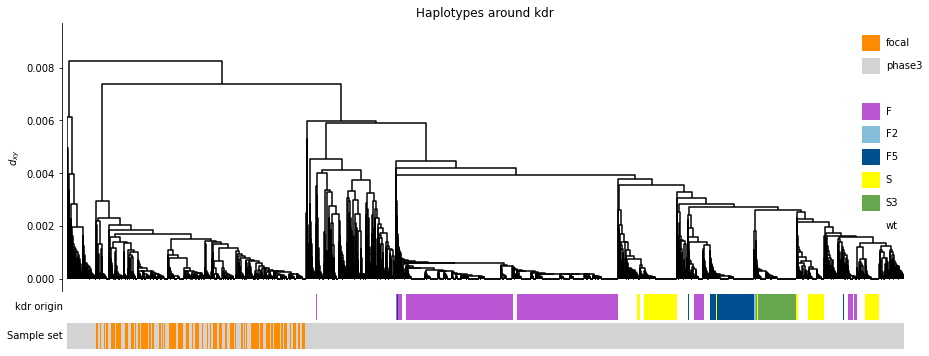

In [18]:
# define dictionary of kdr colors
kdr_colours = {
 'wt' : "white",
 'F'  : "mediumorchid",
 'F1' : "#B0E2F2",    
 'F2' : "#84BEDA",
 'F3' : "#5899C1",
 'F4' : "#276FA9",
 'F5' : "#004F90",
 'S'  : "yellow",
 'S1' : "#C6F39E",
 'S2' : "#96CD76",
 'S3' : "#66A64E",
 'S4' : "#357F26",
 'S5' : "#055901",
 'unkn' : "grey"
}

sample_set_colours = {
    'focal' : 'darkorange',
    'phase3' : 'lightgray'
}

kdr_background = np.concatenate([phase3_kdr_hap_origins['kdr_origin'], 
                                 focal_kdr_hap_origins['kdr_origin'].values])

sample_sets = np.concatenate([np.repeat('phase3', len(phase3_kdr_hap_origins)), 
                              np.repeat('focal', len(focal_kdr_hap_origins))])

draw_hap_cluster_plot(z, combined_kdr_hap_array, 
                      set_colour_scheme = sample_set_colours, 
                      kdr_colour_scheme = kdr_colours,
                      labels_for_set_colours = sample_sets, 
                      labels_for_kdr_colours = kdr_background, 
                      title = 'Haplotypes around kdr',
                      fn = 'kdr_haplotype_clustering.png'
)

/tmp/ipykernel_736860/2969796205.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase3_species[~np.isin(phase3_species, ['arabiensis', 'coluzzii', 'gambiae'])] = 'other'


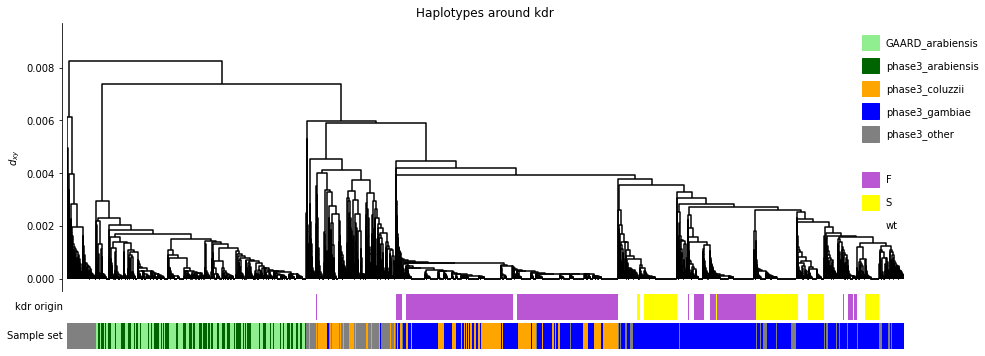

In [19]:
# There are so many haplotype backgrounds that can't be defined due to the SNPs being missing 
# in the gamb_colu_arab filter that I think it is clearer to just plot the presence of F and S,
# rather than the backgrounds. 
def kdr_origin_to_type(kdr):
    if kdr[0] == 'F':
        return('F')
    elif kdr[0] == 'S':
        return('S')
    else:
        return(kdr)
    
kdr_type = np.concatenate([phase3_kdr_hap_origins['kdr_origin'].apply(kdr_origin_to_type), 
                           focal_kdr_hap_origins['kdr_origin'].apply(kdr_origin_to_type)])

# Also, let's include species in our sample set label
phase3_meta = (
    ag3.sample_metadata('3.0')
    .set_index('sample_id')
    .loc[phase3_hap_calls.samples]
)
phase3_species = phase3_meta.taxon
phase3_species[~np.isin(phase3_species, ['arabiensis', 'coluzzii', 'gambiae'])] = 'other'

sample_set_colours = {
    'GAARD_arabiensis' : 'lightgreen',
    'phase3_gambiae' : 'blue',
    'phase3_coluzzii' : 'orange',
    'phase3_arabiensis' : 'darkgreen',
    'phase3_other' : 'grey'
}

sample_sets = np.concatenate(['phase3_' + np.repeat(phase3_species, 2), 
                              np.repeat('GAARD_arabiensis', len(focal_kdr_hap_origins))])

draw_hap_cluster_plot(z, combined_kdr_hap_array, 
                      set_colour_scheme = sample_set_colours, 
                      kdr_colour_scheme = kdr_colours,
                      labels_for_set_colours = sample_sets, 
                      labels_for_kdr_colours = kdr_type, 
                      title = 'Haplotypes around kdr',
                      fn = 'kdr_haplotype_clustering.png'
)

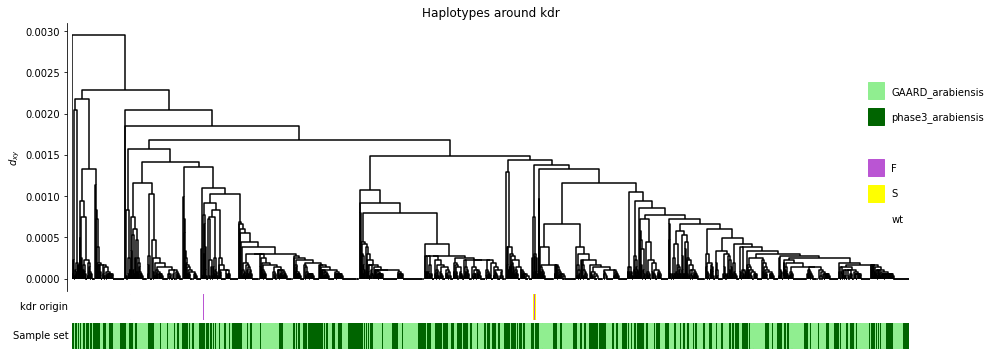

In [20]:
# In order to focus in on the arabiensis haplotypes, let's just plot those
arab_kdr_hap_array = (
    kdr_hap_array[:, np.repeat(phase3_species == 'arabiensis', 2)]
    .concatenate(focal_kdr_hap_array, axis = 1)
)

# And remove non-segregating sites
ac = arab_kdr_hap_array.count_alleles()
# Filter the datasets, removing non-segregating variants 
arab_kdr_hap_array = arab_kdr_hap_array[ac.is_segregating()]

dist = allel.pairwise_distance(arab_kdr_hap_array, metric = 'hamming')
dist_dxy = dist * arab_kdr_hap_array.n_variants / n_bases
z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")

phase3_kdr_hap_origins_arab = phase3_kdr_hap_origins.loc[np.repeat(phase3_species == 'arabiensis', 2), :]
kdr_type = np.concatenate([phase3_kdr_hap_origins_arab['kdr_origin'].apply(kdr_origin_to_type), 
                           focal_kdr_hap_origins['kdr_origin'].apply(kdr_origin_to_type)])

sample_sets = np.concatenate([np.repeat('phase3_arabiensis', np.sum(phase3_species == 'arabiensis')*2), 
                              np.repeat('GAARD_arabiensis', len(focal_kdr_hap_origins))])

draw_hap_cluster_plot(z, arab_kdr_hap_array, 
                      set_colour_scheme = sample_set_colours, 
                      kdr_colour_scheme = kdr_colours,
                      labels_for_set_colours = sample_sets, 
                      labels_for_kdr_colours = kdr_type, 
                      title = 'Haplotypes around kdr',
                      fn = 'kdr_haplotype_clustering_arabiensis.png'
)

In [21]:
# In order for those kdr haplotypes to stand out, we reduce the sample size of wt haplotypes by 
# keeping just 25 haplotypes from each country in phase3. All of the kdr mutants are in Burkina Faso, 
# which has just 3 samples, so these will remain. 
np.random.seed(42)
phase3_meta_arab = phase3_meta.query("taxon == 'arabiensis'")
max_pop_size = 30
keep_phase3_indices = []
for country in np.unique(phase3_meta_arab['country']):
    country_indices = np.where(np.repeat(phase3_meta_arab['country'], 2) == country)[0]
    if len(country_indices) <= max_pop_size:
        keep_phase3_indices += [country_indices]
    else:
        keep_phase3_indices += [np.random.choice(country_indices, size = max_pop_size, replace = False)]

keep_phase3_indices = np.sort(np.concatenate(keep_phase3_indices))

# Now keep the wt haplotypes, plus the 2 mutant ones, from GAARD
keep_focal_indices = [np.where(focal_kdr_hap_origins['kdr_origin'] != 'wt')[0],
                      np.random.choice(np.where(focal_kdr_hap_origins['kdr_origin'] == 'wt')[0], size = max_pop_size, replace = False)]    
keep_focal_indices = np.sort(np.concatenate(keep_focal_indices))

In [22]:
arab_reduced_kdr_hap_array = (
    kdr_hap_array[:, np.repeat(phase3_species == 'arabiensis', 2)][:, keep_phase3_indices]
    .concatenate(focal_kdr_hap_array[:, keep_focal_indices], axis = 1)
)

# And remove non-segregating sites
ac = arab_reduced_kdr_hap_array.count_alleles()
# Filter the datasets, removing non-segregating variants 
arab_reduced_kdr_hap_array = arab_reduced_kdr_hap_array[ac.is_segregating()]

dist = allel.pairwise_distance(arab_reduced_kdr_hap_array, metric = 'hamming')
dist_dxy = dist * arab_reduced_kdr_hap_array.n_variants / n_bases
z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")



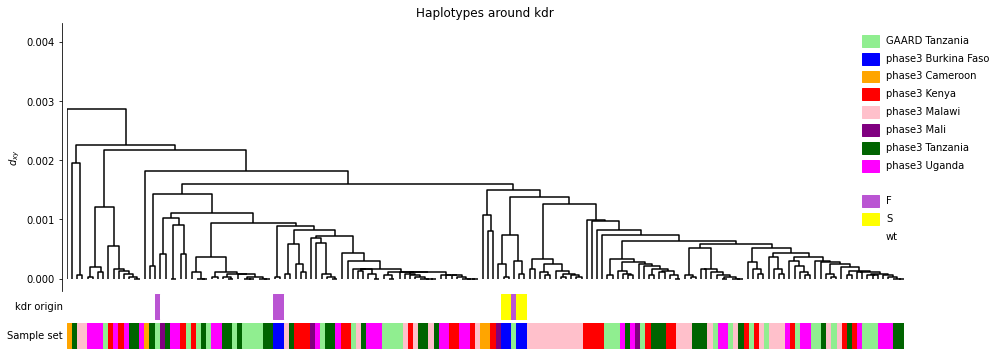

In [23]:
sample_set_colours = {
    'GAARD Tanzania' : 'lightgreen',
    'phase3 Burkina Faso' : 'blue',
    'phase3 Cameroon' : 'orange',
    'phase3 Kenya' : 'red',
    'phase3 Malawi' : 'pink',
    'phase3 Mali': 'purple',
    'phase3 Tanzania': 'darkgreen',
    'phase3 Uganda' : 'magenta'
}

kdr_type = np.concatenate([phase3_kdr_hap_origins_arab['kdr_origin'].iloc[keep_phase3_indices].apply(kdr_origin_to_type), 
                           focal_kdr_hap_origins['kdr_origin'].iloc[keep_focal_indices].apply(kdr_origin_to_type)])

sample_sets = np.concatenate(['phase3 ' + np.repeat(phase3_meta_arab['country'], 2).iloc[keep_phase3_indices], 
                              np.repeat('GAARD Tanzania', len(keep_focal_indices))])

draw_hap_cluster_plot(z, arab_reduced_kdr_hap_array, 
                      set_colour_scheme = sample_set_colours, 
                      kdr_colour_scheme = kdr_colours,
                      labels_for_set_colours = sample_sets, 
                      labels_for_kdr_colours = kdr_type, 
                      title = 'Haplotypes around kdr',
                      fn = 'kdr_haplotype_clustering_arabiensis_reduced.png'
)

In [24]:
# Let's do the same with a larger genomic window
hap_cluster_region_enlarged = '2L:2300000-2440000'

# Get haplotypes for all of vobs arabiensis
kdr_region_arab_enlarged_haps = ag3.haplotypes(region = hap_cluster_region_enlarged, 
                                               analysis = 'gamb_colu_arab',
                                               sample_sets = '3.0',
                                               sample_query = 'taxon == "arabiensis"', 

)

kdr_arab_enlarged_hap_array = allel.GenotypeArray(kdr_region_arab_enlarged_haps.call_genotype).to_haplotypes()

kdr_region_focal_enlarged_haps = ag3.haplotypes(region = hap_cluster_region_enlarged, 
                                                analysis = 'gamb_colu_arab',
                                                sample_sets = sample_set,
                                                sample_query=f"partner_sample_id not in {list(exclude)}"

)

focal_kdr_enlarged_hap_array = allel.GenotypeArray(kdr_region_focal_enlarged_haps.call_genotype).to_haplotypes()

# An unfortunate and unhelpful object name. "reduced" because it includes a reduced set of
# individuals, "enlarged" because it contains an enlarged set of SNPs
arab_reduced_kdr_enlarged_hap_array = (
    kdr_arab_enlarged_hap_array[:, keep_phase3_indices]
    .concatenate(focal_kdr_enlarged_hap_array[:, keep_focal_indices], axis = 1)
)

# And remove non-segregating sites
ac = arab_reduced_kdr_enlarged_hap_array.count_alleles()
# Filter the datasets, removing non-segregating variants 
arab_reduced_kdr_enlarged_hap_array = arab_reduced_kdr_enlarged_hap_array[ac.is_segregating()]
arab_reduced_kdr_enlarged_hap_array

<HaplotypeArray shape=(1033, 162) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [25]:
dist = allel.pairwise_distance(arab_reduced_kdr_enlarged_hap_array, metric = 'hamming')
site_filter_enlarged = ag3.snp_calls(region=hap_cluster_region_enlarged)['variant_filter_pass_gamb_colu_arab']
n_bases_enlarged = np.sum(site_filter_enlarged.values)
dist_dxy = dist * arab_reduced_kdr_enlarged_hap_array.n_variants / n_bases_enlarged

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")

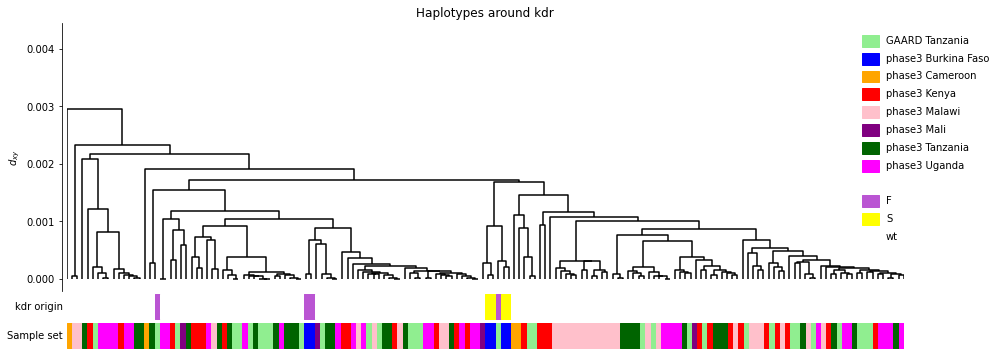

In [26]:
draw_hap_cluster_plot(z, arab_reduced_kdr_enlarged_hap_array, 
                      set_colour_scheme = sample_set_colours, 
                      kdr_colour_scheme = kdr_colours,
                      labels_for_set_colours = sample_sets, 
                      labels_for_kdr_colours = kdr_type, 
                      title = 'Haplotypes around kdr',
                      fn = 'kdr_haplotype_clustering_arabiensis_reduced_broader_region.png'
)